In [1]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models


c:\Users\emada\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [ ]:
import numpy as np
import os
import cv2
from PIL import Image  
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

BATCH_SIZE = 16  
IMG_SIZE = 256  

class LungCancerDataset(Dataset):
    def __init__(self, base_dir, transform=None):
        self.base_dir = base_dir
        self.img_size = IMG_SIZE
        self.transform = transform
        self.data = self._load_data_paths()

    def _load_data_paths(self):
        data = []
        for patient_folder in sorted(os.listdir(self.base_dir)):
            patient_path = os.path.join(self.base_dir, patient_folder)
            for nodule_folder in sorted(os.listdir(patient_path)):
                image_dir = os.path.join(patient_path, nodule_folder, 'images')
                mask_dirs = [
                    os.path.join(patient_path, nodule_folder, f'mask-{i}') for i in range(4)
                ]
                if not os.path.exists(image_dir) or not all(os.path.exists(mask_dir) for mask_dir in mask_dirs):
                    continue
                for img_name in sorted(os.listdir(image_dir)):
                    img_path = os.path.join(image_dir, img_name)
                    mask_paths = [os.path.join(mask_dir, img_name) for mask_dir in mask_dirs]
                    data.append((img_path, mask_paths))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path, mask_paths = self.data[index]
        img = Image.open(img_path).convert('RGB')
        masks = [Image.open(mask_path).convert('L') for mask_path in mask_paths]

        # Resize images and masks
        img = img.resize((self.img_size, self.img_size))
        masks = [mask.resize((self.img_size, self.img_size)) for mask in masks]

        # Combine masks using an element-wise maximum
        masks_np = [np.array(mask, dtype=np.float32) / 255.0 for mask in masks]
        combined_mask = np.maximum.reduce(masks_np)  # Use maximum to combine masks
        combined_mask = (combined_mask > 0.5).astype(np.float32)  # Apply a threshold to binarize

        # Convert to tensors
        if self.transform:
            img = self.transform(img)
        else:
            img = torch.tensor(np.array(img, dtype=np.float32).transpose(2, 0, 1) / 255.0)  # Normalize image

        combined_mask = torch.tensor(combined_mask).unsqueeze(0)  # Add channel dimension

        return img, combined_mask

# Define transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# Instantiate the dataset
base_dir = 'dataset_new/LIDC-IDRI-slices'
full_dataset = LungCancerDataset(base_dir, transform=transform)
total_size = len(full_dataset)

# Define split sizes
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_subset, val_subset, test_subset = random_split(full_dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Example to iterate over the DataLoader
for imgs, masks in train_loader:
    print(f"Train Images batch shape: {imgs.shape}")
    print(f"Train Masks batch shape: {masks.shape}")
    break

for imgs, masks in val_loader:
    print(f"Validation Images batch shape: {imgs.shape}")
    print(f"Validation Masks batch shape: {masks.shape}")
    break

for imgs, masks in test_loader:
    print(f"Test Images batch shape: {imgs.shape}")
    print(f"Test Masks batch shape: {masks.shape}")
    break


In [4]:
train_size

10883

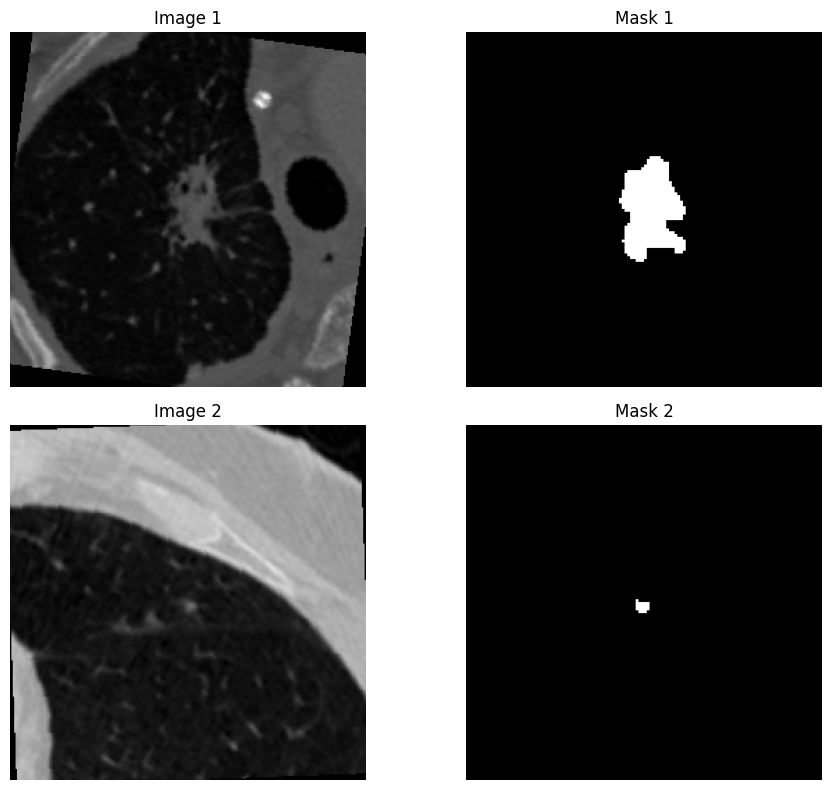

In [5]:
import matplotlib.pyplot as plt

# Get the first batch of images and masks
imgs, masks = next(iter(train_loader))

# Convert images and masks to NumPy arrays for plotting
img1 = imgs[0].permute(1, 2, 0).cpu().numpy()  # Convert from (C, H, W) to (H, W, C)
mask1 = masks[0].squeeze().cpu().numpy()       # Remove the channel dimension from the mask

img2 = imgs[1].permute(1, 2, 0).cpu().numpy()
mask2 = masks[1].squeeze().cpu().numpy()

# Plot the images and masks
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

axes[0, 0].imshow(img1)
axes[0, 0].set_title("Image 1")
axes[0, 0].axis("off")

axes[0, 1].imshow(mask1, cmap="gray")
axes[0, 1].set_title("Mask 1")
axes[0, 1].axis("off")

axes[1, 0].imshow(img2)
axes[1, 0].set_title("Image 2")
axes[1, 0].axis("off")

axes[1, 1].imshow(mask2, cmap="gray")
axes[1, 1].set_title("Mask 2")
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()


In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
from tqdm import tqdm
import torch.cuda.amp as amp  # For mixed precision training

import torch
import torch.nn as nn

# Placeholder for SS2DModule
class SS2DModule(nn.Module):
    def __init__(self, in_channels):
        super(SS2DModule, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x




In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

import numpy as np
import os
import cv2
from PIL import Image  
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

class ModifiedResNet50WithSS2D(nn.Module):
    def __init__(self):
        super(ModifiedResNet50WithSS2D, self).__init__()
        # Load pre-trained ResNet50
        self.base_model = models.resnet50(pretrained=True)
        self.base_layers = nn.Sequential(*list(self.base_model.children())[:-2])  # Remove the fully connected layers

        # SS2D blocks for feature refinement
        self.ss2d_1 = SS2DModule(2048)
        self.ss2d_2 = SS2DModule(512)
        self.ss2d_3 = SS2DModule(256)

        # Define upsampling layers
        self.conv1 = nn.Conv2d(2048, 512, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(256, 64, kernel_size=3, padding=1)
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x = self.base_layers(x)  # Pass through base layers

        # Apply SS2DModule for feature refinement
        x = self.ss2d_1(x)
        x = F.relu(self.conv1(x))
        x = F.interpolate(x, size=(128, 128), mode='bilinear', align_corners=True)

        x = self.ss2d_2(x)
        x = F.relu(self.conv2(x))
        x = F.interpolate(x, size=(256, 256), mode='bilinear', align_corners=True)

        x = self.ss2d_3(x)
        x = F.relu(self.conv3(x))
        x = self.final_conv(x)  # Final convolution (no sigmoid)
        return x  # Return raw logits


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ModifiedResNet50WithSS2D().to(device)  # Move the model to the primary device
model = nn.DataParallel(model)  # Wrap the model with DataParallel

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Load the checkpoint
checkpoint = torch.load('/kaggle/input/lidc-model/best_model.pth')
if 'module' in list(checkpoint['model_state_dict'].keys())[0]:  # Check if the model was saved with DataParallel
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    # Load the state_dict directly if no 'module' prefix
    model.module.load_state_dict(checkpoint['model_state_dict'])

# Load optimizer state
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Load other variables
start_epoch = checkpoint['epoch'] + 1  # Start from the next epoch
best_val_loss = checkpoint['best_val_loss']

# Set model to evaluation mode
model.eval()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 101MB/s]
/tmp/ipykernel_23/1938413380.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possi

DataParallel(
  (module): ModifiedResNet50WithSS2D(
    (base_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [9]:
scaler = amp.GradScaler()

# Model checkpointing and early stopping
best_val_loss = float('inf')
patience = 5
early_stop_counter = 0

/tmp/ipykernel_23/878434646.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


In [10]:
import torch
import torch.nn as nn

# Dice Loss function
def dice_loss(pred, target, smooth=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = 1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth))
    return loss.mean()

# Updated Combined Loss function
class CombinedLoss(nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.bce_with_logits = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss

    def forward(self, pred, target):
        pred = pred.contiguous()
        target = target.contiguous()
        intersection = (torch.sigmoid(pred) * target).sum(dim=2).sum(dim=2)
        dice_loss = 1 - ((2. * intersection + 1e-6) / (torch.sigmoid(pred).sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + 1e-6))
        dice_loss = dice_loss.mean()
        bce_loss = self.bce_with_logits(pred, target)  # Use BCEWithLogitsLoss
        return bce_loss + dice_loss

loss_function = CombinedLoss()

In [11]:
def dice_coefficient(preds, targets, epsilon=1e-6):
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum()
    dice = (2. * intersection + epsilon) / (union + epsilon)
    return dice

def iou(preds, targets, epsilon=1e-6):
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    iou_score = (intersection + epsilon) / (union + epsilon)
    return iou_score

def precision(preds, targets, epsilon=1e-6):
    true_positive = (preds * targets).sum()
    predicted_positive = preds.sum()
    precision_score = (true_positive + epsilon) / (predicted_positive + epsilon)
    return precision_score

def recall(preds, targets, epsilon=1e-6):
    true_positive = (preds * targets).sum()
    actual_positive = targets.sum()
    recall_score = (true_positive + epsilon) / (actual_positive + epsilon)
    return recall_score

def accuracy(preds, targets):
    correct = (preds == targets).sum().float()
    total = targets.numel()
    accuracy_score = correct / total
    return accuracy_score


In [12]:


dice_scores, iou_scores, precision_scores, recall_scores, accuracy_scores = [], [], [], [], []

with torch.no_grad():
    for inputs, masks in val_loader:
        inputs, masks = inputs.to(device), masks.to(device)
        
        # Get predictions
        outputs = model(inputs)
        outputs = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
        
        # Binarize predictions
        preds = (outputs > 0.5).float()

        # Calculate metrics for each batch
        dice_score = dice_coefficient(preds, masks)
        iou_score = iou(preds, masks)
        precision_score = precision(preds, masks)
        recall_score = recall(preds, masks)
        accuracy_score = accuracy(preds, masks)

        # Append to lists
        dice_scores.append(dice_score)
        iou_scores.append(iou_score)
        precision_scores.append(precision_score)
        recall_scores.append(recall_score)
        accuracy_scores.append(accuracy_score)

# Calculate mean scores
mean_dice = torch.mean(torch.stack(dice_scores)).item()
mean_iou = torch.mean(torch.stack(iou_scores)).item()
mean_precision = torch.mean(torch.stack(precision_scores)).item()
mean_recall = torch.mean(torch.stack(recall_scores)).item()
mean_accuracy = torch.mean(torch.stack(accuracy_scores)).item()

print(f"Mean Dice Score: {mean_dice}")
print(f"Mean IoU Score: {mean_iou}")
print(f"Mean Precision: {mean_precision}")
print(f"Mean Recall: {mean_recall}")
print(f"Mean Accuracy: {mean_accuracy}")

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Mean Dice Score: 0.866792619228363
Mean IoU Score: 0.7661170363426208
Mean Precision: 0.8653732538223267
Mean Recall: 0.869544267654419
Mean Accuracy: 0.9974638819694519


In [13]:
for name, module in model.module.named_modules():
    print(name)



base_model
base_model.conv1
base_model.bn1
base_model.relu
base_model.maxpool
base_model.layer1
base_model.layer1.0
base_model.layer1.0.conv1
base_model.layer1.0.bn1
base_model.layer1.0.conv2
base_model.layer1.0.bn2
base_model.layer1.0.conv3
base_model.layer1.0.bn3
base_model.layer1.0.relu
base_model.layer1.0.downsample
base_model.layer1.0.downsample.0
base_model.layer1.0.downsample.1
base_model.layer1.1
base_model.layer1.1.conv1
base_model.layer1.1.bn1
base_model.layer1.1.conv2
base_model.layer1.1.bn2
base_model.layer1.1.conv3
base_model.layer1.1.bn3
base_model.layer1.1.relu
base_model.layer1.2
base_model.layer1.2.conv1
base_model.layer1.2.bn1
base_model.layer1.2.conv2
base_model.layer1.2.bn2
base_model.layer1.2.conv3
base_model.layer1.2.bn3
base_model.layer1.2.relu
base_model.layer2
base_model.layer2.0
base_model.layer2.0.conv1
base_model.layer2.0.bn1
base_model.layer2.0.conv2
base_model.layer2.0.bn2
base_model.layer2.0.conv3
base_model.layer2.0.bn3
base_model.layer2.0.relu
base_mod

In [14]:
!pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 54.3 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39587 sha256=4e38e7f85c701e9ffc6d29253136549566908f9dd49a552ffa803bb99dfbfe4f
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


In [15]:
import cv2
import numpy as np
import torch
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, EigenGradCAM, LayerCAM, FullGrad
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torch.utils.data import DataLoader
import os

# output_folder = 'gradcam'
# os.makedirs(output_folder, exist_ok=True)

# Define custom target for segmentation task
class SegmentationTarget:
    def __init__(self, class_index=None):
        self.class_index = class_index

    def __call__(self, model_output):
        # Check the dimensions of model_output
        if model_output.dim() == 4:  # [batch_size, num_classes, height, width]
            if self.class_index is not None:
                # Sum over the specified class index to get a scalar
                return model_output[:, self.class_index, :, :].sum()
            else:
                # Sum over all classes if no specific class is given
                return model_output.sum()
        elif model_output.dim() == 3:  # [batch_size, height, width] (single channel)
            return model_output.sum()  # Sum over the single channel
        else:
            raise ValueError("Unexpected model output shape")

# Choose the CAM method to apply (e.g., GradCAM, ScoreCAM, etc.)
cam_method = "gradcam"  # You can change this to any supported method
methods = {
    "gradcam": GradCAM,
    "scorecam": ScoreCAM,
    "gradcam++": GradCAMPlusPlus,
    "ablationcam": AblationCAM,
    "xgradcam": XGradCAM,
    "eigencam": EigenCAM,
    "eigengradcam": EigenGradCAM,
    "layercam": LayerCAM,
    "fullgrad": FullGrad
}


In [16]:
target_layer = model.module.final_conv

In [17]:
cam_method = "gradcam"
target_layers = [target_layer]  # Use the appropriate layer in your model

# Initialize the chosen CAM method
cam = methods[cam_method](model=model, target_layers=target_layers)

# Define a test DataLoader if not already defined
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Loop through the test loader
output_dir = 'output/gradcam'
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Define a test DataLoader if not already defined
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Loop through the test loader
for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels  # Load labels if needed

    # Apply CAM for each image in the batch
    for j in range(images.size(0)):
        input_image = images[j].unsqueeze(0)
        rgb_img = input_image[0].cpu().numpy().transpose(1, 2, 0)
        rgb_img = np.float32(rgb_img) / 255

        # Generate CAM using SegmentationTarget, adjust class_index as needed
        targets = [SegmentationTarget(class_index=1)]  # Set to None for single-channel outputs
        grayscale_cam = cam(input_tensor=input_image, targets=targets)
        grayscale_cam = grayscale_cam[0, :]  # Take the first image in the batch

        # Overlay CAM on the image
        cam_image = show_cam_on_image(rgb_img, grayscale_cam)

        # Save the CAM image to the output directory
        output_path = os.path.join(output_dir, f'{cam_method}_cam_image_{i*images.size(0) + j}.jpg')
        cv2.imwrite(output_path, cam_image)
#         print(f"Saved CAM image: {output_path}")

    # Break if you only want to test on a few batches
    if i == 10:
        break

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


In [18]:
import os
import cv2
import matplotlib.pyplot as plt


cam_method = "scorecam"
# Define the output directory
output_dir = 'output/scorecam'
os.makedirs(output_dir, exist_ok=True) 

for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels  # Load labels if needed

    # Apply CAM for each image in the batch
    for j in range(images.size(0)):
        input_image = images[j].unsqueeze(0)
        rgb_img = input_image[0].cpu().numpy().transpose(1, 2, 0)
        rgb_img = np.float32(rgb_img) / 255

        # Generate CAM using SegmentationTarget, adjust class_index as needed
        targets = [SegmentationTarget(class_index=1)]  # Set to None for single-channel outputs
        grayscale_cam = cam(input_tensor=input_image, targets=targets)
        grayscale_cam = grayscale_cam[0, :]  # Take the first image in the batch

        # Overlay CAM on the image
        cam_image = show_cam_on_image(rgb_img, grayscale_cam)

        # Save the CAM image to the output directory
        output_path = os.path.join(output_dir, f'{cam_method}_cam_image_{i*images.size(0) + j}.jpg')
        cv2.imwrite(output_path, cam_image)
#         print(f"Saved CAM image: {output_path}")

    # Break if you only want to test on a few batches
    if i == 10:
        break
